## <p style = "text-align: center; font-weight: bold;">Analyzing New Vehicle Registrations in Canada</p>

-----------------------------------------------------------------------------------------
#### <p style = "text-align: center; font-weight: bold;">Importing Data</p>
-----------------------------------------------------------------------------------------

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month, when, sum, year, greatest
from pyspark.sql import Row
import plotly.express as px
import pandas as pd
import folium
from branca.colormap import linear
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Create a SparkSession
spark = SparkSession.builder \
    .appName("New Vehicle Registrations") \
    .getOrCreate()

# Load data from CSV file
df = spark.read.csv("Dataset/OriginalData.csv", header=True, inferSchema=True, multiLine=True, escape='"') # multiLine=True, escape='"' to handle multiline reviews

24/04/10 02:15:19 WARN Utils: Your hostname, Bikins-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.53 instead (on interface en0)
24/04/10 02:15:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/10 02:15:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 58170)
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 761, in __init__
    self.handle()
  File "/Users/bikinghimire/Projects/NewVehicleRegistrati

-----------------------------------------------------------------------------------------
#### <p style = "text-align: center; font-weight: bold;">Checking Data for cleaning</b>
-----------------------------------------------------------------------------------------

In [4]:
# Print the schema of the data
df.printSchema()

root
 |-- REF_DATE: timestamp (nullable = true)
 |-- GEO: string (nullable = true)
 |-- DGUID: string (nullable = true)
 |-- Fuel type: string (nullable = true)
 |-- Vehicle type: string (nullable = true)
 |-- Statistics: string (nullable = true)
 |-- UOM: string (nullable = true)
 |-- UOM_ID: integer (nullable = true)
 |-- SCALAR_FACTOR: string (nullable = true)
 |-- SCALAR_ID: integer (nullable = true)
 |-- VECTOR: string (nullable = true)
 |-- COORDINATE: string (nullable = true)
 |-- VALUE: integer (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- SYMBOL: string (nullable = true)
 |-- TERMINATED: string (nullable = true)
 |-- DECIMALS: integer (nullable = true)



In [5]:
# Show the dataframe
df.show()

+-------------------+------+--------------+----------------+--------------------+------------------+-----+------+-------------+---------+-----------+----------+------+------+------+----------+--------+
|           REF_DATE|   GEO|         DGUID|       Fuel type|        Vehicle type|        Statistics|  UOM|UOM_ID|SCALAR_FACTOR|SCALAR_ID|     VECTOR|COORDINATE| VALUE|STATUS|SYMBOL|TERMINATED|DECIMALS|
+-------------------+------+--------------+----------------+--------------------+------------------+-----+------+-------------+---------+-----------+----------+------+------+------+----------+--------+
|2017-01-01 00:00:00|Canada|2016A000011124|  All fuel types| Total, vehicle type|Number of vehicles|Units|   300|        units|        0|v1271719067|   1.1.1.1|425043|  NULL|  NULL|      NULL|       0|
|2017-01-01 00:00:00|Canada|2016A000011124|  All fuel types|      Passenger cars|Number of vehicles|Units|   300|        units|        0|v1271719074|   1.1.2.1|130741|  NULL|  NULL|      NULL|

In [6]:
# Show total rows of data
total_rows = df.count()
print("Total rows of data:", total_rows)

Total rows of data: 10780


In [7]:
# Show unique dates
df.select("Ref_date").distinct().show(truncate=False)

+-------------------+
|Ref_date           |
+-------------------+
|2021-01-01 00:00:00|
|2022-04-01 00:00:00|
|2019-01-01 00:00:00|
|2022-10-01 00:00:00|
|2022-07-01 00:00:00|
|2021-10-01 00:00:00|
|2021-04-01 00:00:00|
|2018-07-01 00:00:00|
|2020-10-01 00:00:00|
|2022-01-01 00:00:00|
|2021-07-01 00:00:00|
|2020-04-01 00:00:00|
|2018-01-01 00:00:00|
|2018-04-01 00:00:00|
|2023-10-01 00:00:00|
|2023-01-01 00:00:00|
|2019-07-01 00:00:00|
|2023-04-01 00:00:00|
|2020-07-01 00:00:00|
|2017-01-01 00:00:00|
+-------------------+
only showing top 20 rows



In [8]:
# Show unique GEO location
df.select("GEO").distinct().show(truncate=False)

# Calculate the sum of values for each GEO location
geo_sum = df.groupBy("GEO").sum().select("GEO", "sum(value)").withColumnRenamed("sum(value)", "sum_value")

# Filter the GEO locations with sum of values less than 100
filtered_geo = geo_sum.filter(geo_sum.sum_value > 100)

# Show the unique GEO locations
filtered_geo.select("GEO").distinct().show(truncate=False)

+------------------------------------+
|GEO                                 |
+------------------------------------+
|Manitoba                            |
|Nova Scotia                         |
|Newfoundland and Labrador           |
|Alberta                             |
|New Brunswick                       |
|Saskatchewan                        |
|Prince Edward Island                |
|Ontario                             |
|Quebec                              |
|Canada                              |
|British Columbia and the Territories|
+------------------------------------+

+------------------------------------+
|GEO                                 |
+------------------------------------+
|Manitoba                            |
|New Brunswick                       |
|Saskatchewan                        |
|Prince Edward Island                |
|Ontario                             |
|Quebec                              |
|Canada                              |
|British Columbia and th

In [9]:
# Show unique vehicle type
df.select("Vehicle type").distinct().show(truncate=False)

# Calculate the sum of values for each vehicle type
vehicle_sum = df.groupBy("Vehicle type").sum().select("Vehicle type", "sum(value)").withColumnRenamed("sum(value)", "sum_value")

# Filter the vehicle types with sum of values less than 1000
filtered_vehicle = vehicle_sum.filter(vehicle_sum.sum_value > 1000)

# Show the unique vehicle types
filtered_vehicle.select("Vehicle type").distinct().show(truncate=False)

+----------------------+
|Vehicle type          |
+----------------------+
|Passenger cars        |
|Multi-purpose vehicles|
|Pickup trucks         |
|Vans                  |
|Total, vehicle type   |
+----------------------+

+----------------------+
|Vehicle type          |
+----------------------+
|Passenger cars        |
|Multi-purpose vehicles|
|Pickup trucks         |
|Vans                  |
|Total, vehicle type   |
+----------------------+



In [10]:
# Show unique fuel type
df.select("Fuel type").distinct().show(truncate=False)

# Calculate the sum of values for each fuel type
fuel_sum = df.groupBy("Fuel type").sum().select("Fuel type", "sum(value)").withColumnRenamed("sum(value)", "sum_value")

# Filter the GEO locations with sum of values less than 100
filtered_fuel = fuel_sum.filter(fuel_sum.sum_value > 1000)

# Show the unique GEO locations
filtered_fuel.select("Fuel type").distinct().show(truncate=False)

+-----------------------+
|Fuel type              |
+-----------------------+
|Other fuel types       |
|Gasoline               |
|Diesel                 |
|Hybrid electric        |
|All fuel types         |
|Plug-in hybrid electric|
|Battery electric       |
+-----------------------+

+-----------------------+
|Fuel type              |
+-----------------------+
|Other fuel types       |
|Gasoline               |
|Diesel                 |
|Hybrid electric        |
|All fuel types         |
|Plug-in hybrid electric|
|Battery electric       |
+-----------------------+



In [11]:
# Show unique Statistics
df.select("Statistics").distinct().show(truncate=False)

+------------------+
|Statistics        |
+------------------+
|Number of vehicles|
+------------------+



In [12]:
# Selecting only the necessary columns and renaming the ref_date column to Date
selected_df = df.select(col("ref_date").alias("Date"), col("geo").alias("Location"), "Fuel Type", "Vehicle Type", col("value").alias("Registrations"))


# Printing the new dataframe
selected_df.show()
selected_df.count()

+-------------------+--------+----------------+--------------------+-------------+
|               Date|Location|       Fuel Type|        Vehicle Type|Registrations|
+-------------------+--------+----------------+--------------------+-------------+
|2017-01-01 00:00:00|  Canada|  All fuel types| Total, vehicle type|       425043|
|2017-01-01 00:00:00|  Canada|  All fuel types|      Passenger cars|       130741|
|2017-01-01 00:00:00|  Canada|  All fuel types|       Pickup trucks|        89797|
|2017-01-01 00:00:00|  Canada|  All fuel types|Multi-purpose veh...|       176937|
|2017-01-01 00:00:00|  Canada|  All fuel types|                Vans|        27568|
|2017-01-01 00:00:00|  Canada|        Gasoline| Total, vehicle type|       403087|
|2017-01-01 00:00:00|  Canada|        Gasoline|      Passenger cars|       125547|
|2017-01-01 00:00:00|  Canada|        Gasoline|       Pickup trucks|        78414|
|2017-01-01 00:00:00|  Canada|        Gasoline|Multi-purpose veh...|       173243|
|201

10780

-----------------------------------------------------------------------------------------
#### <p style = "text-align: center; font-weight: bold;">Data Cleaning</p>
-----------------------------------------------------------------------------------------

In [13]:
# Removing rows of data for Newfoundland and Labrador, Nova Scotia and Alberta because their are currently not available due to contractual limitations of the existing data sharing agreement, however, they are included in the Canada total.

selected_df = selected_df[~selected_df['Location'].isin(['Newfoundland and Labrador', 'Nova Scotia', 'Alberta'])]
selected_df.count()

7840

In [14]:
# Removing rows of data for "Other fuel types" because the data is too low and negligible

selected_df = selected_df[~selected_df['Fuel Type'].isin(['Other fuel types'])]
selected_df.count()

6720

In [15]:
# Removing rows of data for All fuel types because it can be easily aggregated though df API

selected_df = selected_df.filter(selected_df["Fuel Type"] != "All fuel types")
selected_df.count()

5600

In [16]:
# Removing rows of data for Total vehicle types because it can be easily aggregated though df API

selected_df = selected_df.filter(selected_df["Vehicle Type"] != "Total, vehicle type")
selected_df.count()

4480

In [17]:
# Changing the name of the location "British Columbia and the Territories" to "British Columbia"

selected_df = selected_df.withColumn("Location", when(selected_df["Location"] == "British Columbia and the Territories", "British Columbia").otherwise(selected_df["Location"]))

In [18]:
selected_df.show()

+-------------------+--------+--------------------+--------------------+-------------+
|               Date|Location|           Fuel Type|        Vehicle Type|Registrations|
+-------------------+--------+--------------------+--------------------+-------------+
|2017-01-01 00:00:00|  Canada|            Gasoline|      Passenger cars|       125547|
|2017-01-01 00:00:00|  Canada|            Gasoline|       Pickup trucks|        78414|
|2017-01-01 00:00:00|  Canada|            Gasoline|Multi-purpose veh...|       173243|
|2017-01-01 00:00:00|  Canada|            Gasoline|                Vans|        25883|
|2017-01-01 00:00:00|  Canada|              Diesel|      Passenger cars|          264|
|2017-01-01 00:00:00|  Canada|              Diesel|       Pickup trucks|        11383|
|2017-01-01 00:00:00|  Canada|              Diesel|Multi-purpose veh...|          973|
|2017-01-01 00:00:00|  Canada|              Diesel|                Vans|         1663|
|2017-01-01 00:00:00|  Canada|    Battery e

-----------------------------------------------------------------------------------------
#### <p style = "text-align: center; font-weight: bold;">Data Analysis</p>
-----------------------------------------------------------------------------------------

In [19]:
# Extract the month and year from the Date column
df_with_month_year = selected_df.withColumn("Month", month("Date")).withColumn("Year", year("Date"))

# Create the Quarter column based on the Month column
df_with_quarter = df_with_month_year.withColumn("Quarter", when(df_with_month_year["Month"] == 1, "Quarter 1")
                                                        .when(df_with_month_year["Month"] == 4, "Quarter 2")
                                                        .when(df_with_month_year["Month"] == 7, "Quarter 3")
                                                        .when(df_with_month_year["Month"] == 10, "Quarter 4")
                                                        .otherwise(df_with_month_year["Month"]))

# Drop the Date and Month columns
final_df = df_with_quarter.drop("Date", "Month")

# Sort the data in final_df based on the specified column sequence
final_df = final_df.select("Year", "Quarter", "Fuel Type", "Vehicle Type", "Location", "Registrations") \
                          .orderBy("Year", "Quarter", "Fuel Type", "Vehicle Type", "Location", "Registrations")


final_df.show()

+----+---------+----------------+--------------------+--------------------+-------------+
|Year|  Quarter|       Fuel Type|        Vehicle Type|            Location|Registrations|
+----+---------+----------------+--------------------+--------------------+-------------+
|2017|Quarter 1|Battery electric|Multi-purpose veh...|    British Columbia|          162|
|2017|Quarter 1|Battery electric|Multi-purpose veh...|              Canada|          531|
|2017|Quarter 1|Battery electric|Multi-purpose veh...|            Manitoba|            0|
|2017|Quarter 1|Battery electric|Multi-purpose veh...|       New Brunswick|            1|
|2017|Quarter 1|Battery electric|Multi-purpose veh...|             Ontario|          181|
|2017|Quarter 1|Battery electric|Multi-purpose veh...|Prince Edward Island|            0|
|2017|Quarter 1|Battery electric|Multi-purpose veh...|              Quebec|          159|
|2017|Quarter 1|Battery electric|Multi-purpose veh...|        Saskatchewan|            0|
|2017|Quar

In [20]:
# Filter the dataframe to include only the year 2023
df_2023 = final_df.filter(final_df["Year"] == 2023)

# Calculate the sum of registrations in the year 2023
total_registrations_2023 = df_2023.selectExpr("sum(Registrations)").collect()[0][0]

# Print the total registrations in the year 2023
print("Total registrations in the year 2023:", total_registrations_2023)

Total registrations in the year 2023: 3151573


In [24]:
# Group the data by Year and sum the Registrations column
df_year_sum = final_df.groupBy("Year").agg(sum("Registrations").alias('Total Registrations'))

df_year_sum = df_year_sum.orderBy("Year")

# Convert the Spark DataFrame to a Pandas DataFrame
df_year_sum_pd = df_year_sum.toPandas()

# Create a line chart using Plotly
fig = px.line(df_year_sum_pd, x='Year', y='Total Registrations', title='Total Registrations by Year')

# Display the line chart
fig.show()


In [67]:
# Group the data by Quarter and sum the Registrations column
df_quarter_sum = final_df.groupBy("Quarter").agg(sum("Registrations").alias('Total Registrations'))

df_quarter_sum_pd = df_quarter_sum.toPandas()

# Create a pie chart using Plotly
fig = px.pie(df_quarter_sum_pd, values='Total Registrations', names='Quarter', title='Total Registrations by Quarter', color_discrete_sequence=px.colors.sequential.Blugrn, width=500, height=500)

# Display the pie chart
fig.show()

In [78]:
# Group the data by Date and sum the Registrations column
df_date_sum = selected_df.groupby("Date").agg(sum("Registrations").alias("TotalRegistrations"))

df_date_sum = df_date_sum.orderBy("Date")

# Convert the Spark DataFrame to a Pandas DataFrame
df_date_sum_pd = df_date_sum.toPandas()

# Create a line chart using Plotly
fig = px.line(df_date_sum_pd, x='Date', y='TotalRegistrations', title='Total Registrations by Date', color_discrete_sequence=['teal'], width=800, height=500)

# Display the line chart
fig.show()


In [81]:
# Group the data by Location and sum the Registrations column
df_location_sum = final_df.filter(selected_df["Location"] != "Canada").groupBy("Location").agg(sum("Registrations").alias("TotalRegistrations"))

df_location_sum_pd = df_location_sum.toPandas()

# Find the highest and lowest average overall ratings
highest_registrations = df_location_sum_pd["TotalRegistrations"].max()
lowest_registrations = df_location_sum_pd["TotalRegistrations"].min()

# Create a bar chart using Plotly
fig = px.bar(df_location_sum_pd, x='Location', y='TotalRegistrations', title='Total Registrations by Location')

# Highlight the highest and lowest ratings
fig.update_traces(marker_color=['teal' if rating == highest_registrations else 'red' if rating == lowest_registrations else 'lightblue' for rating in df_location_sum_pd["TotalRegistrations"]])

# Display the bar chart
fig.show()

In [34]:
# Create new rows for missing provinces
new_rows = [
    Row(Location='Newfoundland and Labrador', TotalRegistrations=0),
    Row(Location='Nova Scotia', TotalRegistrations=0),
    Row(Location='Alberta', TotalRegistrations=0)
]

# Create a new DataFrame with the new rows
new_df = spark.createDataFrame(new_rows)

# Union the new DataFrame with the original DataFrame
df_location_sum_new = df_location_sum.union(new_df)

# Show the updated DataFrame
df_location_sum_new.show()

+--------------------+------------------+
|            Location|TotalRegistrations|
+--------------------+------------------+
|            Manitoba|            341158|
|       New Brunswick|            264643|
|        Saskatchewan|            337954|
|Prince Edward Island|             49691|
|             Ontario|           4895143|
|    British Columbia|           1475147|
|              Quebec|           2981557|
|Newfoundland and ...|                 0|
|         Nova Scotia|                 0|
|             Alberta|                 0|
+--------------------+------------------+



In [40]:
colormap = linear.YlGn_09.scale(
    df_location_sum_pd.TotalRegistrations.min(), df_location_sum_pd.TotalRegistrations.max()
)

print(colormap(5.0))

colormap

#ffffe5ff


In [42]:
# Convert the Spark DataFrame to a Pandas DataFrame
df_location_sum_new_pd = df_location_sum_new.toPandas()

# Create a dictionary to map the location values to coordinates
registration_dict = df_location_sum_new_pd.set_index("Location")["TotalRegistrations"]

In [62]:
# Load the GeoJSON data
geo_json_data = "canada_provinces.geo.json"

# Create a map centered around Canada
m = folium.Map(location=[53, -95], zoom_start=4)

# Add the GeoJSON data to the map
folium.GeoJson(
    geo_json_data,
    name="Total Registrations",
    style_function=lambda feature: {
        "fillColor": colormap(registration_dict[feature["properties"]["name"]]),
        "color": "black",
        "weight": 2,
        "dashArray": "5, 5",
        "fillOpacity": 1,
    },
    highlight_function=lambda x: {"weight": 3, "fillOpacity": 0.7},
    smooth_factor=2.0,
).add_to(m)

# Adding a colorbar to the map
colormap.caption = "Total Registrations by Location"
colormap.add_to(m)

# Display the map
m

In [85]:
# Group the data by Vehicle Type and sum the Registrations column
df_vehicle_type_sum = final_df.groupBy("Vehicle Type").agg(sum("Registrations").alias("TotalRegistrations"))

df_vehicle_type_sum_pd = df_vehicle_type_sum.toPandas()

# Create a bar chart using Plotly
fig = px.bar(df_vehicle_type_sum_pd, x='Vehicle Type', y='TotalRegistrations', title='Total Registrations by Vehicle Type', color_discrete_sequence=px.colors.sequential.Blugrn, width=500, height=500)

# Display the bar chart
fig.show()

In [86]:
# Group the data by Fuel Type and sum the Registrations column
df_fuel_type_sum = final_df.groupBy("Fuel Type").agg(sum("Registrations").alias("TotalRegistrations"))

df_fuel_type_sum_pd = df_fuel_type_sum.toPandas()

# Create a bar chart using Plotly
fig = px.bar(df_fuel_type_sum_pd, x='Fuel Type', y='TotalRegistrations', title='Total Registrations by Fuel Type', color_discrete_sequence=px.colors.sequential.Blugrn, width=500, height=500)

# Display the bar chart
fig.show()

In [21]:
# Group the data by Location and Year and sum the Registrations column
df_location_year_sum = final_df.filter(selected_df["Location"] != "Canada").groupBy("Year", "Location").sum("Registrations")

df_location_year_sum = df_location_year_sum.orderBy("Year", "Location")

# Convert the Spark DataFrame to a Pandas DataFrame
df_location_year_sum_pd = df_location_year_sum.toPandas()

# Create a line chart using Plotly
fig = px.line(df_location_year_sum_pd, x='Year', y='sum(Registrations)', color='Location', title='Overall Registrations by Location (2017-2023)')

# Display the line chart
fig.show()

+----+--------------------+------------------+
|Year|            Location|sum(Registrations)|
+----+--------------------+------------------+
|2017|British Columbia ...|            247718|
|2017|            Manitoba|             58310|
|2017|       New Brunswick|             43932|
|2017|             Ontario|            801431|
|2017|Prince Edward Island|              8859|
|2017|              Quebec|            474263|
|2017|        Saskatchewan|             56525|
|2018|British Columbia ...|            230083|
|2018|            Manitoba|             53979|
|2018|       New Brunswick|             40961|
|2018|             Ontario|            798537|
|2018|Prince Edward Island|              7929|
|2018|              Quebec|            464208|
|2018|        Saskatchewan|             52267|
|2019|British Columbia ...|            217965|
|2019|            Manitoba|             51344|
|2019|       New Brunswick|             40558|
|2019|             Ontario|            795985|
|2019|Prince 

In [89]:
# Group the data by Year and Vehicle Type and sum the Registrations column
df_year_vehicle_sum = final_df.groupBy("Year", "Vehicle Type").agg(sum("Registrations").alias("TotalRegistrations"))

df_year_vehicle_sum = df_year_vehicle_sum.orderBy("Year", "Vehicle Type")

df_year_vehicle_sum_pd = df_year_vehicle_sum.toPandas()

# Create a line chart using Plotly
fig = px.line(df_year_vehicle_sum_pd, x='Year', y='TotalRegistrations', color='Vehicle Type', title='Overall Registrations by Vehicle Type (2017-2023)', width=500, height=500)

# Position the legend horizontally at the top
fig.update_layout(
    legend_orientation="h",
    legend=dict(x=0.5, y=1.1, xanchor='center')
)

# Display the line chart
fig.show()


In [92]:
# Group the data by Year and Fuel Type and sum the Registrations column
df_year_fuel_sum = final_df.groupBy("Year", "Fuel Type").agg(sum("Registrations").alias("TotalRegistrations"))

df_year_fuel_sum = df_year_fuel_sum.orderBy("Year", "Fuel Type")

df_year_fuel_sum_pd = df_year_fuel_sum.toPandas()

# Create a line chart using Plotly
fig = px.line(df_year_fuel_sum_pd, x='Year', y='TotalRegistrations', color='Fuel Type', title='Overall Registrations by Fuel Type (2017-2023)', width=500, height=500)

# Position the legend horizontally at the top
fig.update_layout(
    legend_orientation="h",
    legend=dict(x=0.5, y=1.1, xanchor='center')
)

# Display the line chart
fig.show()


In [93]:
# Group the data by Year and Fuel Type and sum the Registrations column
df_year_fuel_sum_1 = final_df.filter(selected_df["Fuel Type"] != "Gasoline").groupBy("Year", "Fuel Type").agg(sum("Registrations").alias("TotalRegistrations"))

df_year_fuel_sum_1 = df_year_fuel_sum_1.orderBy("Year", "Fuel Type")

df_year_fuel_sum_pd_1 = df_year_fuel_sum_1.toPandas()

# Create a line chart using Plotly
fig = px.line(df_year_fuel_sum_pd_1, x='Year', y='TotalRegistrations', color='Fuel Type', title='Overall Registrations by Fuel Type (2017-2023)', width=500, height=500)

# Position the legend horizontally at the top
fig.update_layout(
    legend_orientation="h",
    legend=dict(x=0.5, y=1.1, xanchor='center')
)

# Display the line chart
fig.show()

In [95]:
# Group the data by Location and Quarter and sum the Registrations column
df_location_quarter_sum = final_df.filter(selected_df["Location"] != "Canada").groupBy("Quarter", "Location").agg(sum("Registrations").alias("TotalRegistrations"))

# Convert the Spark DataFrame to a Pandas DataFrame
df_location_quarter_sum_pd = df_location_quarter_sum.toPandas()

# Create a bar chart using Plotly
fig = px.bar(df_location_quarter_sum_pd, x='Location', y='TotalRegistrations', color='Quarter', title='Total Registrations by Location and Quarter')

# Display the bar chart
fig.show()


In [96]:
# Group the data by Quarter and Vehicle Type and sum the Registrations column
df_quarter_vehicle_sum = final_df.groupBy("Quarter", "Vehicle Type").agg(sum("Registrations").alias("TotalRegistrations"))

# Create a bar chart using Plotly
fig = px.bar(df_quarter_vehicle_sum, x='Vehicle Type', y='TotalRegistrations', color='Quarter', title='Total Registrations Quarterly by Vehicle Type')

# Display the bar chart
fig.show()


In [97]:
# Group the data by Location and find the fuel type with the highest registrations
fuel_type_preference = final_df.groupBy("Location").pivot("Fuel Type").agg(sum("Registrations").alias("TotalRegistrations"))

# Find the fuel type with the highest registrations for each location
fuel_type_preference = fuel_type_preference.withColumn("Highest_Fuel_Type", greatest(*[col(c) for c in fuel_type_preference.columns[1:]]))

# Display the fuel type preference for each location
fuel_type_preference.show()


+--------------------+----------------+------+--------+---------------+-----------------------+-----------------+
|            Location|Battery electric|Diesel|Gasoline|Hybrid electric|Plug-in hybrid electric|Highest_Fuel_Type|
+--------------------+----------------+------+--------+---------------+-----------------------+-----------------+
|            Manitoba|            2469| 10875|  316719|           9494|                   1601|           316719|
|       New Brunswick|            2002|  7479|  246066|           7611|                   1485|           246066|
|        Saskatchewan|            1699| 26417|  301485|           7295|                   1058|           301485|
|Prince Edward Island|             639|  1479|   45635|           1583|                    355|            45635|
|             Ontario|          112336|137596| 4423668|         180480|                  41063|          4423668|
|    British Columbia|          109145| 81082| 1178607|          75657|                 

-----------------------------------------------------------------------------------------
#### <p style = "text-align: center; font-weight: bold;">Predictive Analysis</p>
-----------------------------------------------------------------------------------------

In [98]:
gasoline_df = selected_df.filter(selected_df["Fuel Type"] == "Gasoline").groupBy("Date", "Fuel Type").sum("Registrations")

gasoline_df = gasoline_df.orderBy("Date")

# Convert the Spark DataFrame to a Pandas DataFrame
gasoline_df_pd = gasoline_df.toPandas()

# Set 'Date' column as index
gasoline_df_pd.set_index('Date', inplace=True)
gasoline_df_pd.index = pd.to_datetime(gasoline_df_pd.index)

# Ensure the DataFrame is sorted by Date (if not already sorted)
gasoline_df_pd = gasoline_df_pd.sort_index()


/Users/bikinghimire/Projects/NewVehicleRegistrations/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/bikinghimire/Projects/NewVehicleRegistrations/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/bikinghimire/Projects/NewVehicleRegistrations/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



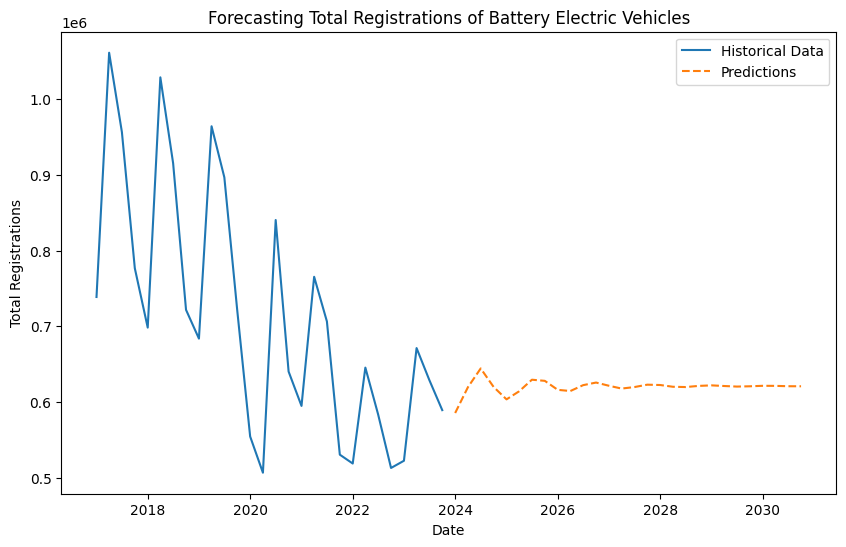

In [99]:
# Fit ARIMA model
model = ARIMA(gasoline_df_pd['sum(Registrations)'], order=(5, 1, 0))  # Using the entire data for training
fitted_model = model.fit()

# Make predictions for the next 7 years (assuming quarterly data)
forecast_steps = 28  # 7 years * 4 quarters/year = 28 quarters
index = pd.date_range(start='2024-01-01', periods=forecast_steps)  # Generate date indices for predictions
predictions = fitted_model.forecast(steps=forecast_steps)

# Create a DataFrame for predictions with appropriate date index
predictions_df = pd.DataFrame({'Predictions': predictions})

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(gasoline_df_pd.index, gasoline_df_pd['sum(Registrations)'], label='Historical Data')
plt.plot(predictions_df.index, predictions_df['Predictions'], label='Predictions', linestyle='--')
plt.title('Forecasting Total Registrations of Battery Electric Vehicles')
plt.xlabel('Date')
plt.ylabel('Total Registrations')
plt.legend()

plt.show()

In [100]:
ebattery_df = selected_df.filter(selected_df["Fuel Type"] == "Battery electric").groupBy("Date", "Fuel Type").sum("Registrations")

ebattery_df = ebattery_df.orderBy("Date")

# Convert the Spark DataFrame to a Pandas DataFrame
ebattery_df_pd = ebattery_df.toPandas()

# Set 'Date' column as index
ebattery_df_pd.set_index('Date', inplace=True)
ebattery_df_pd.index = pd.to_datetime(ebattery_df_pd.index)

# Ensure the DataFrame is sorted by Date (if not already sorted)
ebattery_df_pd = ebattery_df_pd.sort_index()

/Users/bikinghimire/Projects/NewVehicleRegistrations/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/bikinghimire/Projects/NewVehicleRegistrations/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/Users/bikinghimire/Projects/NewVehicleRegistrations/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



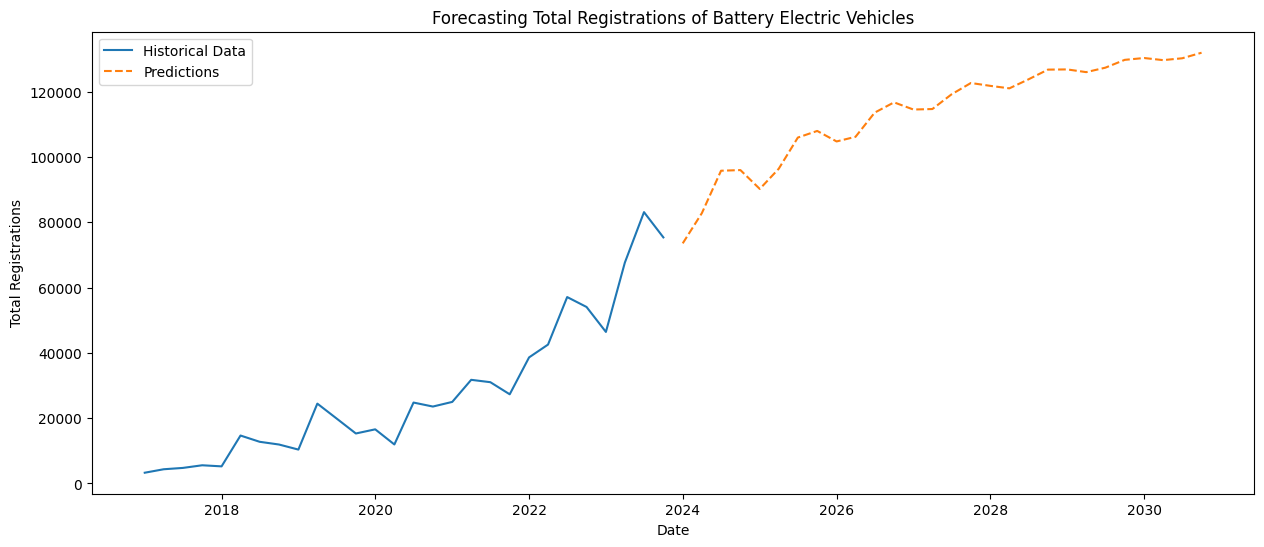

24/04/10 06:27:36 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 294795 ms exceeds timeout 120000 ms
24/04/10 06:27:36 WARN SparkContext: Killing executors is not supported by current scheduler.
24/04/10 06:27:39 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [101]:
# Fit ARIMA model
model = ARIMA(ebattery_df_pd['sum(Registrations)'], order=(5, 1, 0))  # Using the entire data for training
fitted_model = model.fit()

# Make predictions for the next 7 years (assuming quarterly data)
forecast_steps = 28  # 7 years * 4 quarters/year = 28 quarters
index = pd.date_range(start='2024-01-01', periods=forecast_steps)  # Generate date indices for predictions
predictions = fitted_model.forecast(steps=forecast_steps)

# Create a DataFrame for predictions with appropriate date index
predictions_df = pd.DataFrame({'Predictions': predictions})

# Visualize predictions
plt.figure(figsize=(15, 6))
plt.plot(ebattery_df_pd.index, ebattery_df_pd['sum(Registrations)'], label='Historical Data')
plt.plot(predictions_df.index, predictions_df['Predictions'], label='Predictions', linestyle='--')
plt.title('Forecasting Total Registrations of Battery Electric Vehicles')
plt.xlabel('Date')
plt.ylabel('Total Registrations')
plt.legend()

plt.show()

In [ ]:
# Stopping the SparkSession
spark.stop()